In [2]:
import h5py
import numpy as np
import torchvision.transforms.v2 as transforms
from scipy.signal import fftconvolve
import torch
from tqdm import tqdm
from astropy.convolution import Gaussian2DKernel

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

In [3]:
hf = h5py.File("../../.data/Galaxy10_DECals.h5", "r")

In [4]:
#im = hf["images"][2100]


def numpy_to_tensor(image):
    return torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

def tensor_to_numpy(im_tensor):
    im_tensor = torch.clamp(im_tensor * 255.0, 0, 255)
    return im_tensor.permute(1, 2, 0).byte().numpy()

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianNoise(mean = 0.0, sigma = 0.1, clip=True),
    transforms.ColorJitter(brightness = 0.4, contrast=0,saturation=0.5,hue=0),
])

def augmented_class(hf, class_index, target_count=2600):
    
    labels = np.array(hf["ans"])
    images = hf["images"]

    original_indices = np.where(labels == class_index)[0]
    needed_count = target_count - len(original_indices)

    print(f"[Class {class_index}] Current: {len(original_indices)}, Adding: {needed_count}")

    augmented_images = []
    augmented_labels = []

    for _ in tqdm(range(needed_count), desc=f"Augmenting class {class_index}"):
        idx = np.random.choice(original_indices)
        im_np = images[idx]
        im_tensor = numpy_to_tensor(im_np)
        im_aug = transform(im_tensor)
        im_aug_np = tensor_to_numpy(im_aug)
        augmented_images.append(im_aug_np)
        augmented_labels.append(class_index)

    return augmented_images, augmented_labels

  #  new_images = np.concatenate([images[:], np.stack(augmented_images)], axis=0)
  #  new_labels = np.concatenate([labels, np.array(augmented_labels)], axis=0)

  #  print(f"New total images: {new_images.shape[0]}")
  #      # Save to new HDF5 file
  #  with h5py.File("augmented_dataset.h5", "w") as hf_new:
  #      hf_new.create_dataset("images", data=new_images, dtype='uint8')
  #+      hf_new.create_dataset("ans", data=new_labels, dtype='int64')

#im_tensor_transformed = transform(im_tensor)

In [5]:
augmented_im_3, augmented_label_3 = augmented_class(hf, 3)

[Class 3] Current: 2027, Adding: 573


Augmenting class 3: 100%|██████████| 573/573 [05:36<00:00,  1.70it/s]


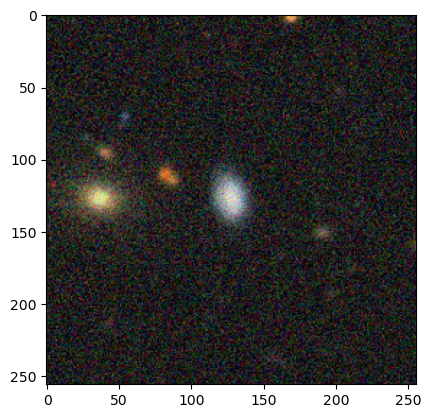

In [26]:
plt.imshow(augmented_im_3[np.random.randint(0,len(augmented_label_3))])

In [ ]:
#underrepresented = [0, 1, 3, 4, 5, 6, 8, 9]
#with h5py.File("../../.data/Galaxy10_DECals.h5", "r") as hf:
#    for cls in underrepresented:
#        add_augmented(hf, class_index=cls)

[Class 0] Current: 1081, Adding: 1519


Augmenting class 0:  97%|█████████▋| 1479/1519 [14:01<00:21,  1.87it/s]

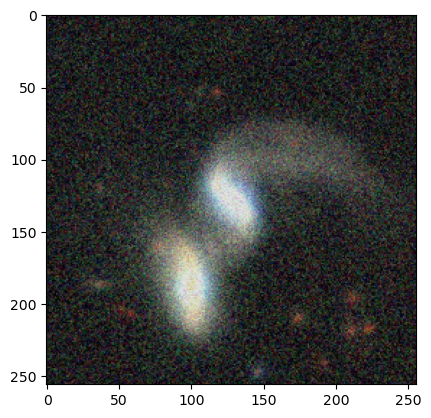

In [174]:
plt.imshow(im_tensor_transformed.permute(1,2,0))

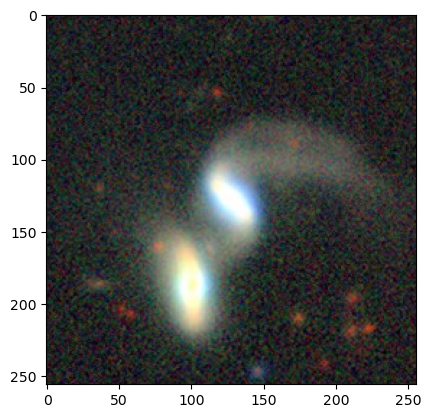

In [149]:
plt.imshow(im_tensor.permute(1,2,0))

In [31]:
img_center = 255 // 2
size = 192
l = img_center - size // 2
r = img_center + size // 2

In [13]:
channels = np.arange(3)
rng.shuffle(channels)

im[..., [0, 1, 2]] = im[..., channels]
rot_count = rng.integers(1, 3)
channels, rot_count

mod_img = np.rot90(im, rot_count)[l:r, l:r, :]
print(mod_img.shape)
#mod_img = np.transpose(
    [fftconvolve(mod_img[..., i], kernel, mode="valid") for i in range(0, 3)]
#)
mod_img = np.transpose([mod_img[..., i] / 255 for i in range(0, 3)])
mod_img.shape

IndentationError: unexpected indent (3947096074.py, line 11)

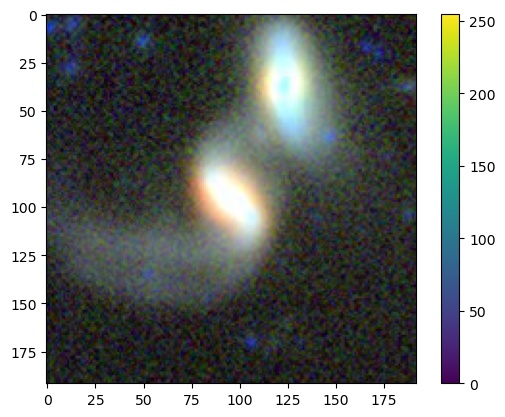

In [14]:
plt.imshow(mod_img)
plt.colorbar()

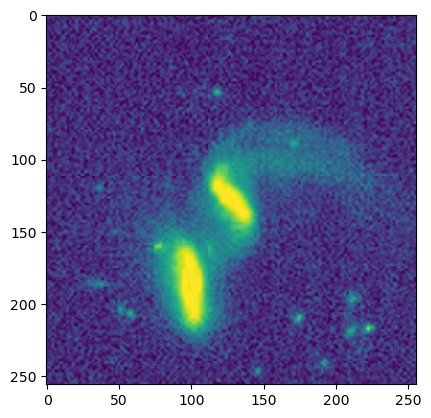

In [15]:
plt.imshow(im[..., 0])

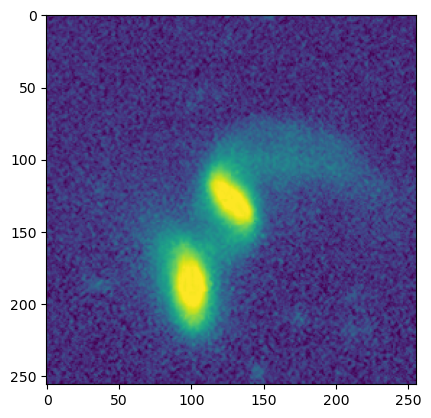

In [16]:
plt.imshow(im[..., 1])

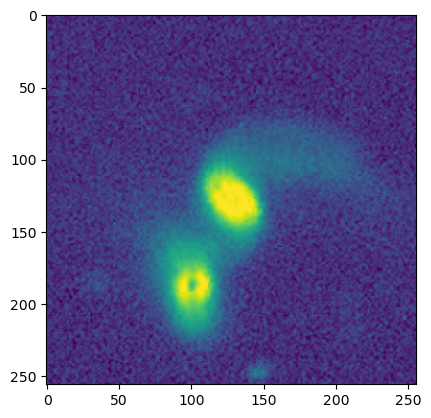

In [17]:
plt.imshow(im[..., 2])